In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from mpl_toolkits.axes_grid1 import ImageGrid
import diverge.output as do

#change to directory of current script
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


def plotBandStructure(mod,save=False):
    #fig = plt.figure(layout="constrained", figsize=(3,2))
    xvals = do.bandstructure_xvals(mod)
    bands = do.bandstructure_bands(mod)
    ymax = np.max(bands)
    ymin = np.min(bands)
    yrange = ymax - ymin
    ybuffer= yrange*0.1
    plt.plot( xvals, bands, c='navy' )
    
    xticks = do.bandstructure_ticks(mod)
    if len(mod.klabels) == len(xticks):
        plt.xticks(xticks, mod.klabels)
    else:
        plt.xticks(xticks, [i for i in range(len(xticks))])

    #print(xticks)
    #exit(0)

    plt.hlines(0, xvals[0], xvals[-1], colors='k',  linestyles='-')
    
    #N_segment = 300
    for i in range(len(xticks)-1):
        plt.vlines(xticks[i], ymin-ybuffer,ymax+ybuffer, colors='k', linestyles='dashed')
        #plt.axvline(steps[i*N_segment], color="black", lw=0.5, linestyle="--")
        #xticks.append(steps[i*N_segment])
        #xticklabels.append(i)
    plt.xlim( xvals[0], xvals[-1] )
    plt.ylim(ymin-ybuffer,ymax+ybuffer)

    plt.xlabel( r'$\mathbf{k}$' )
    plt.ylabel( r'$\epsilon_b({\bf k})$' )


    
    if save==True: 
        plt.savefig('bands.pdf')

    plt.show()



def suscepPlot(mod,out,channel="P",title=""):
    #Channel = "P" "C" or "D"
    no = mod.n_orb
    ns = mod.n_spin
    kmesh = mod.bandstructure[:,-3:]

    ibz_edges = kmesh[::300].T
    ucx, ucy, ucz = mod.lattice.T
    kxv, kyv, kzv = mod.kmesh.T
    kvec = mod.kmesh
    nkx = mod.nk[0]
    nky = mod.nk[1]
    nkz = mod.nk[2]

    # generate real space mesh
    Rx = np.arange(0,nkx,1)
    Ry = np.arange(0,nky,1)
    Rx[Rx>nkx/2-1+1e-5] -= nkx
    Ry[Ry>nky/2-1+1e-5] -= nky

    Rx, Ry = np.meshgrid(Rx,Ry)
    R1 = np.ndarray.flatten(Rx)
    R2 = np.ndarray.flatten(Ry)

    uc1 = np.array([ucx[0],ucy[0],ucz[0]])
    uc2 = np.array([ucx[1],ucy[1],ucz[1]])
    FFT_realspace_vectors = uc1[:,None]*R1[None,:] + uc2[:,None]*R2[None,:]
    

    exponential = np.exp(1j*np.einsum('ir,ki->rk',FFT_realspace_vectors,kvec)) #this is for the Fourier transform somehow?

    if channel == "P":
        susz = out.Psusc
    elif channel == "C":
        susz = out.Csusc
    elif channel == "D":
        susz = out.Dsusc
    else:
        print("Invalid channel")
        return
    
    susz = np.einsum('abcdabcdk->bdk',susz)
    func_R = np.einsum('...k,rk->...r',susz,exponential)
    #generate target mesh
    N_segment = 300
    ibz_path = np.zeros((N_segment*(ibz_edges.shape[1]-1),3))
    steps = np.linspace(0,1,N_segment)

    for edge in range(1,ibz_edges.shape[1]):
        ibz_path[(edge-1)*N_segment:edge*N_segment,:] = (1.-steps[:,None])*ibz_edges[:,edge-1][None,:] + steps[:,None] * ibz_edges[:,edge][None,:]


    steps = np.linspace(0,1,N_segment*(ibz_edges.shape[1]-1))
    exponential = np.exp(-1j*np.einsum('ir,ki->rk',FFT_realspace_vectors,ibz_path))

    ibz_susz = np.einsum('...r,rk->k...',func_R,exponential)/len(kxv)

    k_idx = []
    where_on_path = []
    for i in range(len(kxv)):
        diff_to_all = np.linalg.norm(kvec[i,:][:,None]-ibz_path.transpose(), axis = 0)
        if(np.min(diff_to_all) < 12./N_segment):
            k_idx.append(i)
            where_on_path.append(np.argmin(diff_to_all))

    where_on_path = np.asarray(where_on_path)
    k_idx = np.asarray(k_idx)

    perm = where_on_path.argsort()
    where_on_path = where_on_path[perm]
    k_idx = k_idx[perm]

    lines_maker1 =[]
    fig = plt.figure(figsize=(4.2,3.15))
    ax = fig.add_subplot(111)
    orbc = ["1z2"]
    colors= ["purple"]
    for i in range(no):
        line2 = ax.plot(steps, np.abs(np.real(ibz_susz[:,i,i]))) #lines_maker1.append(line2[0])
        ax.plot(steps[where_on_path],np.abs(np.real(susz[i,i, k_idx])),color =
                    "black",marker=".",linestyle="None")
    #for i in range(no):
    #    for j in range(0,i):
    #        line2 = ax.plot(steps, np.abs(np.real(ibz_susz[:,i,j])),linestyle = "--", label = orbc[i]+";"+orbc[j])
    #        lines_maker1.append(line2[0])

    if channel == "P":
        plt.title("SC susceptibility "+title)
    elif channel == "C":
        plt.title("SDW susceptibility "+title)
    elif channel == "D":
        plt.title("CDW susceptibility "+title)
    else:
        plt.title("suscep? "+title)
    ax.set_ylabel("Chi")
    
    xticks = []
    xticklabels = []
    for i in range(ibz_edges.shape[1]-1):
        ax.axvline(steps[i*N_segment], color="black", lw=0.5, linestyle="--")
        xticks.append(steps[i*N_segment])
        xticklabels.append(i)
    #final line
    ax.axvline(steps[-1], color="black", lw=0.5, linestyle="--")
    xticks.append(steps[-1])
    xticklabels.append(ibz_edges.shape[1])


    ax.set_xticks(xticks)
    if len(mod.klabels) == len(xticks):
        ax.set_xticklabels(mod.klabels)
    else:
        ax.set_xticklabels(xticklabels)
    
    ax.set_xlabel(r"$\mathbf{q}$")



def save_SCgap(data, mod, channel, plot_vector, gap_file="gap_file.txt"):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    #print("plotvectorshape", plot_vector[:,:,7:16].shape)
    plot_vector = np.copy(plot_vector)
    #plot_vector[:,:,7:16] *= 0
    #plot_vector[:,:,18:] *= 0
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    # This gives the evec in ff and orbital space.
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
            #print("TEST", np.allclose(mirr[idx], uniquemiR[j]))
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    #print(uniquemiR)
    #print(Ukooo.shape)
    #exit(0)
    #for i in range(int(len(uniquemiR))):
    #    print(np.abs(  Ukooo[:,:,i]))
    #    print(np.angle(Ukooo[:,:, i]))
    #    print("ff",     uniquemiR[i])
    #    print("ff_lat",     uniquemiR_lat[i])

    f = open(gap_file, "w")
    for i in range(int(len(uniquemiR))):
        Rx = uniquemiR[i][0]
        Ry = uniquemiR[i][1]
        Rz = uniquemiR[i][2]
        for o1 in range(len(Ukooo)):
            for o2 in range(len(Ukoo[o1])):
                line =f"{Rx} {Ry} {Rz} {o1} {o2} {np.real(Ukooo[o1,o2,i])} {np.imag(Ukooo[o1,o2,i])}\n"
                f.write(line)
    f.close()

def plot_SCgap(data, mod, channel, plot_vector, eval, real_space=False):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    #print("plotvectorshape", plot_vector[:,:,7:16].shape)
    plot_vector = np.copy(plot_vector)
    #plot_vector[:,:,7:16] *= 0
    #plot_vector[:,:,18:] *= 0
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    # This gives the evec in ff and orbital space.
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
            #print("TEST", np.allclose(mirr[idx], uniquemiR[j]))
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    #print(uniquemiR)
    #print(Ukooo.shape)
    #exit(0)
    #for i in range(int(len(uniquemiR))):
    #    print(np.abs(  Ukooo[:,:,i]))
    #    print(np.angle(Ukooo[:,:, i]))
    #    print("ff",     uniquemiR[i])
    #    print("ff_lat",     uniquemiR_lat[i])


    
    #sub_lat = np.array([[3.012570, 0, 0], [-1.506285, 2.608962, 0], [1.506285, 2.608962,0]]) # Anja model
    #sub_lat = np.array([[np.sqrt(3)/2, 0, 0], [np.sqrt(3)/2- np.sqrt(3)/4, 1/4, 0], [np.sqrt(3)/2+ np.sqrt(3)/4, 1/4,0]]) # Toy kagome
    #sub_lat = np.array([[3.012570, -1.506285, 1.506285], [0, 2.608962, 2.608962], [0, 0,0]])
    sub_lat = mod.positions
    #print("BREAK")
    #print(sub_lat.shape)
    #print(np.swapaxes(Ukooo,0,2).shape)
    #print(uniquemiR_lat.shape)
    if real_space == True:
        full(uniquemiR_lat, sub_lat, np.swapaxes(Ukooo,0,2), save_path="test")

    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.abs(Ukoo[o1,o2,:]),norm = plt.Normalize(0,np.max(np.abs(Ukoo))), s = 10, linewidths=0.1,cmap="plasma")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
    #plot title in top center of image grid
    center_idx = math.ceil(no*ns/2)-1
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), vmin=-np.pi, vmax=np.pi, s = 10, linewidths=0.1,cmap="twilight") #norm = plt.Normalize(-1,1)
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
            
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    # normalize and gauge maximal value to be real
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.real(Ukoo[o1,o2,:]),norm = norm, s = 10, linewidths=0.1,cmap="bwr")
            #ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), s = 10*np.abs(Ukoo[o1,o2,:]), linewidths=0.1,cmap="twilight")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
            #ax[q].set_title(q)
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])
    plt.show()
    #plt.savefig(filename[:-4]+"real_xy_real.png",bbox_inches='tight',dpi = 600)
    #plt.close("all")


def full(R_list, sublattice, state_to_plot, title=None, save_path=None):
    """
    Plots the absolute value and phase of an eigenstate in the BZ
    """
    c_range = np.array([-np.pi, np.pi])
    cmap = "twilight"
    to_plot = np.angle(state_to_plot)
    dotsize = 90 * np.abs(state_to_plot)
    print("dotsize", dotsize.shape)
    y_label = "Phase"
    for i in range(int(len(R_list))):
        print(dotsize[i,:,:])
        print(to_plot[i,:,:])
        print("ff",     R_list[i])

    real_space(R_list, sublattice, to_plot, dotsize, c_range, cmap,
               y_label, title, save_path)


def real_space(R_list, sublattice, to_plot, dotsize, c_range=None,
               cmap="viridis", y_label=None, title=None, save_path=None):
    """
    Take a function in formfactor space and plots it on the real space mesh
    """
    no = to_plot.shape[-1]
    fig, ax = plt.subplots(1, no)
    ax = np.array(ax).reshape(no) #takes care of case no=1
    if title:
        fig.suptitle(title, fontsize=10, y=1.03, x=0.40)

    if c_range is None:
        c_range = np.array([np.min(np.abs(to_plot)),
                            np.max(np.abs(to_plot))])

    for o0 in range(no):
        # plot reference site
        ax[o0].plot([sublattice[o0, 0]], [sublattice[o0, 1]], "x")
        print(o0)
        print("test", [sublattice[o0, 0]], [sublattice[o0, 1]])
        for o1 in range(no):
            # plot real space distribution
            ax[o0].scatter(R_list[:, 0] + sublattice[o1, 0],
                           R_list[:, 1] + sublattice[o1, 1],
                           dotsize[:, o0, o1], c=to_plot[:, o0, o1],
                           vmin=-np.pi, vmax=np.pi, cmap=cmap)

            ax[o0].set_aspect("equal")
            plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.5)
            ax[o0].set_xticks([])
            ax[o0].set_yticks([])

        ax[-1].set_ylabel("$k_y$")
        ax[-1].set_xlabel("$k_x$")

        norm = plt.Normalize(c_range[0], c_range[1])
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.80, 0.2, 0.03, 0.6])

        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.ax.set_ylabel(y_label)

        if np.allclose(c_range, np.array([-np.pi, np.pi])):
            cbar.set_ticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
            cbar.set_ticklabels(["$-\pi$", "$-\pi/2$", "$0$",
                                 "$\pi/2$", "$\pi$"])

    if save_path:
        fig.savefig(save_path + ".pdf")
    else:
        plt.show()




In [61]:


mu = "1.00"
Uvals = np.arange(0, 20, 0.5)
Uvals_str = [f"{value:.2f}" for value in Uvals]
for i, u in enumerate(Uvals_str):
    print(u)
    nk = 20
    nkf = 5

    ff = "4.00"
    mod = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_mod.dvg")
    mod.klabels = ["G", "M", "X", "G"]

    out = do.read(f"1NN_{nk}_{nkf}_{u}_{mu}_out.dvg")

    # Use the correct axis for plotting
    suscepPlot(mod, out, channel="C", title=f"U = {u}, mu = {mu}")

plt.tight_layout()
plt.show()

0.00


AttributeError: 'NoneType' object has no attribute 'add_subplot'

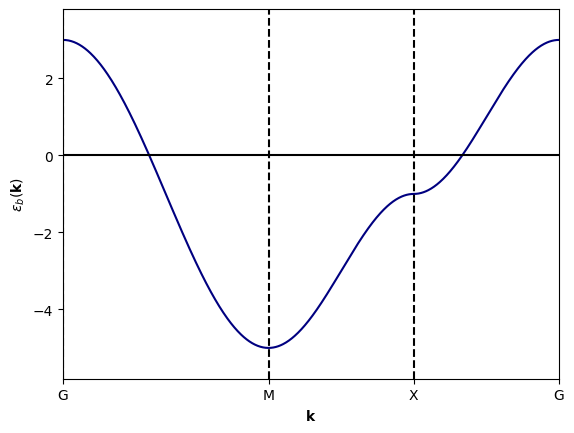

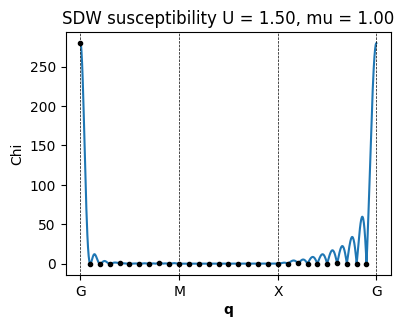

IndexError: index 0 is out of bounds for axis 0 with size 0

In [51]:
def main(Us, mus):
    nk =20
    nkf = 5
    


    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plotBandStructure(mod,save=False)

   # suscepPlot(mod,out,channel="P",title=f"U = {Us}, mu = {mus}")
    suscepPlot(mod,out,channel="C",title=f"U = {Us}, mu = {mus}")
    #suscepPlot(mod,out,channel="D",title=f"U = {Us}, mu = {mus}")
    plt.show()
   
    #mod = do.read("Sr2RuO4_32_4_1.20_0.25_2.01_mod.dvg")
    #out = do.read("Sr2RuO4_32_4_1.20_0.25_2.01_out.dvg")

    #suscepPlot(mod,out,channel="P",title="32_4_2.01")
    #suscepPlot(mod,out,channel="C",title="32_4_2.01")
    #suscepPlot(mod,out,channel="D",title="32_4_2.01")
    #plt.show()

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0],real_space=False)
    #save_SCgap(out,mod,"P",out.Pvec[0],gap_file=f"gap_file_{nk}_{nkf}_{U}_{J}_{ff}.txt")
    

    exit(0)

    return 0

main("1.50", "1.00")

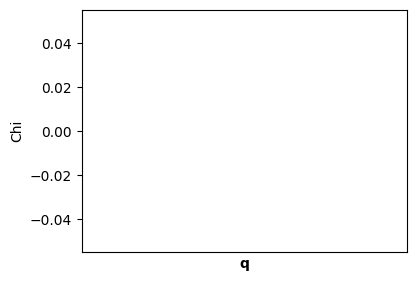

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

def suscepPlotAnimated(nk, nkf, Us_values, mu, channel="P", title="", output_dir="output_images"):
    """
    Animate susceptibility plots for a fixed mu and a range of U values, saving each frame as a JPEG.
    
    Parameters:
        do: The object responsible for reading the .dvg files.
        nk: Number of k-points in one direction (used in the file naming).
        nkf: Another parameter affecting file naming.
        Us_values: List of U values for animation.
        mu: Fixed chemical potential.
        channel: Susceptibility channel ("P", "C", or "D") to plot.
        title: Title for the plot.
        output_dir: Directory to save the animation frames as JPEG files.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Setup the initial plot
    fig, ax = plt.subplots(figsize=(4.2, 3.15))
    ax.set_ylabel("Chi")
    ax.set_xlabel(r"$\mathbf{q}$")
    ax.set_xticks([])
    line, = ax.plot([], [], lw=2)
    
    # Initialize the plot
    def init():
        line.set_data([], [])
        return line,

    # Update function for animation
    def update(frame):
        # Get the current U value (mu is fixed)
        U = Us_values[frame]

        # Load the corresponding mod and out files based on the U value
        mod = do.read(f"1NN_{nk}_{nkf}_{U}_{mu}_mod.dvg")
        out = do.read(f"1NN_{nk}_{nkf}_{U}_{mu}_out.dvg")
        
        # Update mod's mu value
        mod.mu = mu

        # Retrieve necessary model properties
        no = mod.n_orb
        kmesh = mod.bandstructure[:, -3:]
        ibz_edges = kmesh[::300].T
        ucx, ucy, ucz = mod.lattice.T
        kvec = mod.kmesh
        nkx, nky, nkz = mod.nk

        # Generate real space mesh
        Rx = np.arange(0, nkx, 1)
        Ry = np.arange(0, nky, 1)
        Rx[Rx > nkx / 2 - 1 + 1e-5] -= nkx
        Ry[Ry > nky / 2 - 1 + 1e-5] -= nky
        Rx, Ry = np.meshgrid(Rx, Ry)
        R1, R2 = Rx.flatten(), Ry.flatten()

        uc1, uc2 = np.array([ucx[0], ucy[0], ucz[0]]), np.array([ucx[1], ucy[1], ucz[1]])
        FFT_realspace_vectors = uc1[:, None] * R1[None, :] + uc2[:, None] * R2[None, :]

        # IBZ path generation
        N_segment = 300
        ibz_path = np.zeros((N_segment * (ibz_edges.shape[1] - 1), 3))
        steps = np.linspace(0, 1, N_segment)
        for edge in range(1, ibz_edges.shape[1]):
            ibz_path[(edge - 1) * N_segment:edge * N_segment, :] = (
                (1. - steps[:, None]) * ibz_edges[:, edge - 1][None, :] +
                steps[:, None] * ibz_edges[:, edge][None, :]
            )

        steps = np.linspace(0, 1, N_segment * (ibz_edges.shape[1] - 1))
        exponential = np.exp(-1j * np.einsum('ir,ki->rk', FFT_realspace_vectors, ibz_path))

        # Extract the susceptibility data for the selected channel
        if channel == "P":
            susz = out.Psusc
        elif channel == "C":
            susz = out.Csusc
        elif channel == "D":
            susz = out.Dsusc
        else:
            print(f"Invalid channel: {channel}")
            return line,

        susz = np.einsum('abcdabcdk->bdk', susz)
        func_R = np.einsum('...k,rk->...r', susz, exponential)
        ibz_susz = np.einsum('...r,rk->k...', func_R, exponential) / len(kvec)

        # Update the plot title and data
        ax.set_title(f"{title} (U = {U:.2f}, mu = {mu:.2f})")
        line.set_data(steps, np.abs(np.real(ibz_susz[:, 0, 0])))

        # Save the current frame as a JPEG image
        frame_filename = os.path.join(output_dir, f"frame_{frame:03d}.jpg")
        plt.savefig(frame_filename, format="jpeg", dpi=300)
        
        return line,

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(Us_values), init_func=init, blit=True, repeat=True)

    # Close the plot after the animation is done
    plt.close(fig)

# Example usage
# suscepPlotAnimated(do, nk, nkf, Us_values, mu, channel="P", title="


In [ ]:
suscepPlotAnimated(nk=20, nkf=5, Us_values=[1.0, 1.5, 2.0, 2.5], mu=1.0, channel="C", title="Susceptibility Animation")